In [1]:
# start add noise to the image
# what is the relation between error in m vs the noise level applied
# pixel noise vs shape noise (level of 0.2)

# read Dodelson: 1. overview, section 2,4, read section 6,7,8 + magnefication, possibly 9

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/data/groups/jeltema/zhou/lsst_shear/shape-measurement-tutorials/src")


from utils import get_moments, get_elipticity, get_x_y
import galsim, ngmix
import mdet_meas_tools as mmt

In [3]:
import ngmix
import numpy as np


def sim_func(*, g1, g2, seed, psf_fwhm, pixel_noise_std, size_noise_std=0,shape_noise_std=0):
    # this is an RNG you can use to draw random numbers as needed
    # always use this RNG and not np.random directly
    # doing this makes sure the code is reproducible
    
    rng = np.random.RandomState(seed=seed)

    size_nse = rng.normal(loc=0,scale=size_noise_std)
    # make an Exponential object in galsim with a half light radius of 0.5
    gal = galsim.Exponential(half_light_radius=0.5+size_nse)
    
    g1_noise = rng.normal(loc=0,scale=shape_noise_std)
    g2_noise = rng.normal(loc=0,scale=shape_noise_std)

    gal = gal.shear(g1=g1_noise, g2=g2_noise)

    # make a Gaussian object in galsim with a fwhm of `psf_fwhm`
    # psf = galsim.Gaussian(fwhm=psf_fwhm)
    psf = galsim.Moffat(fwhm=0.7, beta=2.5)

    # apply the input shear `g1`, `g2` to the galaxy `gal`
    
    ### draw shear randomly scale=0.3 for shear 
    sheared_gal = gal.shear(g1=g1, g2=g2)

    # here we are going to apply a random shift to the object's center
    dx, dy = 2.0 * (rng.uniform(size=2) - 0.5) * 0.2
    sheared_gal = sheared_gal.shift(dx, dy)

    # convolve the sheared galaxy with the psf
    obj = galsim.Convolve(sheared_gal, psf)

    # render the object and the PSF on odd sized images of 53 pixels on a side with
    # a pixel scale of 0.2
    obj_im = obj.drawImage(scale=0.2, nx=53, ny=53)
    psf_im = psf.drawImage(scale=0.2, nx=53, ny=53)

    # now we are going to add noise to the object image and setup the ngmix data
    cen = (53 - 1) / 2
    nse_sd = pixel_noise_std
    nse = rng.normal(size=obj_im.array.shape, scale=nse_sd)
    nse_im = rng.normal(size=obj_im.array.shape, scale=nse_sd)
    
    jac = ngmix.jacobian.DiagonalJacobian(scale=0.2,
                                          row=cen + dy / 0.2,
                                          col=cen + dx / 0.2)
    psf_jac = ngmix.jacobian.DiagonalJacobian(scale=0.2, row=cen, col=cen)

    # Transformation between pixel and tangent uv coordinate. It has off diag terms if CCD is rotated.
    # in real data we care about off diag terms 

    # we have to add a little noise to the PSf to make things stable
    target_psf_s2n = 500.0
    target_psf_noise = np.sqrt(np.sum(psf_im.array**2)) / target_psf_s2n

    psf_obs = ngmix.Observation(
        image=psf_im.array,
        weight=np.ones_like(psf_im.array) / target_psf_noise**2,
        jacobian=psf_jac,
    )

    # here we build the final observation
    obj_obs = ngmix.Observation(
        image=obj_im.array + nse,
        noise=nse_im,
        weight=np.ones_like(nse_im) / nse_sd**2,
        jacobian=psf_jac,
        bmask=np.zeros_like(nse_im, dtype=np.int32),
        ormask=np.zeros_like(nse_im, dtype=np.int32),
        psf=psf_obs,
    )

    return obj_obs

In [4]:
obs_list_pixel_noise = []
obs_list_size_noise = []
obs_list_shape_noise = []

pixel_noise_std_range = 10**np.linspace(-8,-3,10)
size_noise_std_range = 10**np.linspace(-8,-1,10)
shape_noise_std_range = 10**np.linspace(-8,-1,10)

In [5]:
print(pixel_noise_std_range)
print(shape_noise_std_range)
print(size_noise_std_range)

[1.00000000e-08 3.59381366e-08 1.29154967e-07 4.64158883e-07
 1.66810054e-06 5.99484250e-06 2.15443469e-05 7.74263683e-05
 2.78255940e-04 1.00000000e-03]
[1.00000000e-08 5.99484250e-08 3.59381366e-07 2.15443469e-06
 1.29154967e-05 7.74263683e-05 4.64158883e-04 2.78255940e-03
 1.66810054e-02 1.00000000e-01]
[1.00000000e-08 5.99484250e-08 3.59381366e-07 2.15443469e-06
 1.29154967e-05 7.74263683e-05 4.64158883e-04 2.78255940e-03
 1.66810054e-02 1.00000000e-01]


In [6]:
pixel_noise_std_list = []
for pixel_noise_std_ in pixel_noise_std_range:
    pdata,mdata, m, msd, c, csd, R11  = mmt.run_mdet_sims(sim_func=sim_func,sim_kwargs={'psf_fwhm':0.8, 'pixel_noise_std':pixel_noise_std_,'size_noise_std':0,'shape_noise_std':0},seed=123,n_sims=10)
    pixel_noise_std_list.append((msd,csd))
    res = mmt.estimate_m_and_c(pdata,mdata)

Using both positive and negative shear


    # of sims: 10
    noise cancel m   :  0.371380 +/-  0.000798 [1e-3, 3-sigma]
    noise cancel c   : -0.005462 +/-  0.023009 [1e-5, 3-sigma]


Using both positive and negative shear


Using both positive and negative shear


    # of sims: 10
    noise cancel m   :  0.370133 +/-  0.003026 [1e-3, 3-sigma]
    noise cancel c   : -0.019166 +/-  0.083333 [1e-5, 3-sigma]


Using both positive and negative shear


Using both positive and negative shear


    # of sims: 10
    noise cancel m   :  0.365145 +/-  0.010853 [1e-3, 3-sigma]
    noise cancel c   : -0.067872 +/-  0.300526 [1e-5, 3-sigma]


Using both positive and negative shear


Using both positive and negative shear


    # of sims: 10
    noise cancel m   :  0.348567 +/-  0.039749 [1e-3, 3-sigma]
    noise cancel c   : -0.243440 +/-  1.079692 [1e-5, 3-sigma]


Using both positive and negative shear


Using both positive and negative shear


    # of sims: 10
    noise cancel m   :  0.288742 +/-  0.143142 [1e-3, 3-sigma]
    noise cancel c   : -0.877064 +/-  3.880661 [1e-5, 3-sigma]


Using both positive and negative shear


Using both positive and negative shear


    # of sims: 10
    noise cancel m   :  0.072640 +/-  0.514170 [1e-3, 3-sigma]
    noise cancel c   : -3.134190 +/-  13.947069 [1e-5, 3-sigma]


Using both positive and negative shear


Using both positive and negative shear


    # of sims: 10
    noise cancel m   : -0.644509 +/-  1.843468 [1e-3, 3-sigma]
    noise cancel c   : -10.861036 +/-  50.391597 [1e-5, 3-sigma]


Using both positive and negative shear


Using both positive and negative shear


    # of sims: 10
    noise cancel m   : -3.455444 +/-  6.650484 [1e-3, 3-sigma]
    noise cancel c   : -36.482907 +/-  181.790229 [1e-5, 3-sigma]


Using both positive and negative shear


Using both positive and negative shear


    # of sims: 10
    noise cancel m   : -13.588639 +/-  23.096044 [1e-3, 3-sigma]
    noise cancel c   : -119.790216 +/-  662.044840 [1e-5, 3-sigma]


Using both positive and negative shear


Using both positive and negative shear


    # of sims: 10
    noise cancel m   : -38.687171 +/-  84.511213 [1e-3, 3-sigma]
    noise cancel c   : -418.034108 +/-  2510.719771 [1e-5, 3-sigma]


Using both positive and negative shear


In [7]:
size_noise_std_list = []
for size_noise_std_ in size_noise_std_range:
    # print(f"{size_noise_std_=}")
    pdata,mdata, m, msd, c, csd, R11  = mmt.run_mdet_sims(sim_func=sim_func,sim_kwargs={'psf_fwhm':0.8, 'pixel_noise_std':1e-5,'size_noise_std':size_noise_std_,'shape_noise_std':0},seed=123,n_sims=10)
    size_noise_std_list.append((msd,csd))
    res = mmt.estimate_m_and_c(pdata,mdata)

Using both positive and negative shear


    # of sims: 10
    noise cancel m   : -0.126558 +/-  0.857620 [1e-3, 3-sigma]
    noise cancel c   : -5.173278 +/-  23.290641 [1e-5, 3-sigma]


Using both positive and negative shear


Using both positive and negative shear


    # of sims: 10
    noise cancel m   : -0.126130 +/-  0.857928 [1e-3, 3-sigma]
    noise cancel c   : -5.173392 +/-  23.290636 [1e-5, 3-sigma]


Using both positive and negative shear


Using both positive and negative shear


    # of sims: 10
    noise cancel m   : -0.126439 +/-  0.857517 [1e-3, 3-sigma]
    noise cancel c   : -5.173199 +/-  23.290551 [1e-5, 3-sigma]


Using both positive and negative shear


Using both positive and negative shear


    # of sims: 10
    noise cancel m   : -0.126861 +/-  0.858027 [1e-3, 3-sigma]
    noise cancel c   : -5.173276 +/-  23.290785 [1e-5, 3-sigma]


Using both positive and negative shear


Using both positive and negative shear


    # of sims: 10
    noise cancel m   : -0.126358 +/-  0.857689 [1e-3, 3-sigma]
    noise cancel c   : -5.173416 +/-  23.290769 [1e-5, 3-sigma]


Using both positive and negative shear


Using both positive and negative shear


    # of sims: 10
    noise cancel m   : -0.126889 +/-  0.857731 [1e-3, 3-sigma]
    noise cancel c   : -5.174025 +/-  23.290936 [1e-5, 3-sigma]


Using both positive and negative shear


Using both positive and negative shear


    # of sims: 10
    noise cancel m   : -0.126906 +/-  0.857047 [1e-3, 3-sigma]
    noise cancel c   : -5.175757 +/-  23.288089 [1e-5, 3-sigma]


Using both positive and negative shear


Using both positive and negative shear


    # of sims: 10
    noise cancel m   : -0.125202 +/-  0.857253 [1e-3, 3-sigma]
    noise cancel c   : -5.187381 +/-  23.281399 [1e-5, 3-sigma]


Using both positive and negative shear


Using both positive and negative shear


    # of sims: 10
    noise cancel m   : -0.140096 +/-  0.853582 [1e-3, 3-sigma]
    noise cancel c   : -5.280089 +/-  23.296055 [1e-5, 3-sigma]


Using both positive and negative shear


Using both positive and negative shear


    # of sims: 10
    noise cancel m   : -0.164265 +/-  0.857412 [1e-3, 3-sigma]
    noise cancel c   : -6.039255 +/-  24.210382 [1e-5, 3-sigma]


Using both positive and negative shear


In [9]:
shape_noise_std_list = []
for shape_noise_std_ in shape_noise_std_range:
    print(f"{shape_noise_std_=}")
    pdata,mdata, m, msd, c, csd, R11  = mmt.run_mdet_sims(sim_func=sim_func,sim_kwargs={'psf_fwhm':0.8, 'pixel_noise_std':1e-5,'shape_noise_std':shape_noise_std_},seed=123,n_sims=10)
    shape_noise_std_list.append((msd,csd))
    res = mmt.estimate_m_and_c(pdata,mdata)

shape_noise_std_=1e-08
Using both positive and negative shear


    # of sims: 10
    noise cancel m   : -0.126162 +/-  0.857780 [1e-3, 3-sigma]
    noise cancel c   : -5.173586 +/-  23.290665 [1e-5, 3-sigma]


Using both positive and negative shear


shape_noise_std_=5.99484250318941e-08


Using both positive and negative shear


    # of sims: 10
    noise cancel m   : -0.126550 +/-  0.858109 [1e-3, 3-sigma]
    noise cancel c   : -5.176181 +/-  23.291754 [1e-5, 3-sigma]


Using both positive and negative shear


shape_noise_std_=3.5938136638046254e-07


Using both positive and negative shear


    # of sims: 10
    noise cancel m   : -0.126596 +/-  0.857956 [1e-3, 3-sigma]
    noise cancel c   : -5.200629 +/-  23.300181 [1e-5, 3-sigma]


Using both positive and negative shear


shape_noise_std_=2.1544346900318865e-06


Using both positive and negative shear


    # of sims: 10
    noise cancel m   : -0.126378 +/-  0.857762 [1e-3, 3-sigma]
    noise cancel c   : -5.337710 +/-  23.343757 [1e-5, 3-sigma]


Using both positive and negative shear


shape_noise_std_=1.2915496650148827e-05


Using both positive and negative shear


    # of sims: 10
    noise cancel m   : -0.127070 +/-  0.857343 [1e-3, 3-sigma]
    noise cancel c   : -6.159312 +/-  23.617685 [1e-5, 3-sigma]


Using both positive and negative shear


shape_noise_std_=7.742636826811278e-05


Using both positive and negative shear


    # of sims: 10
    noise cancel m   : -0.127582 +/-  0.857366 [1e-3, 3-sigma]
    noise cancel c   : -11.084991 +/-  25.518190 [1e-5, 3-sigma]


Using both positive and negative shear


shape_noise_std_=0.0004641588833612782


Using both positive and negative shear


    # of sims: 10
    noise cancel m   : -0.128775 +/-  0.858148 [1e-3, 3-sigma]
    noise cancel c   : -40.614360 +/-  42.398895 [1e-5, 3-sigma]


Using both positive and negative shear


shape_noise_std_=0.0027825594022071257


Using both positive and negative shear


    # of sims: 10
    noise cancel m   : -0.126803 +/-  0.856418 [1e-3, 3-sigma]
    noise cancel c   : -217.634960 +/-  172.484830 [1e-5, 3-sigma]


Using both positive and negative shear


shape_noise_std_=0.016681005372000592


Using both positive and negative shear


    # of sims: 10
    noise cancel m   : -0.121600 +/-  0.853916 [1e-3, 3-sigma]
    noise cancel c   : -1279.013088 +/-  977.566650 [1e-5, 3-sigma]


Using both positive and negative shear


shape_noise_std_=0.1


Using both positive and negative shear


    # of sims: 10
    noise cancel m   : -0.117280 +/-  0.837943 [1e-3, 3-sigma]
    noise cancel c   : -7673.827828 +/-  5886.785889 [1e-5, 3-sigma]


Using both positive and negative shear


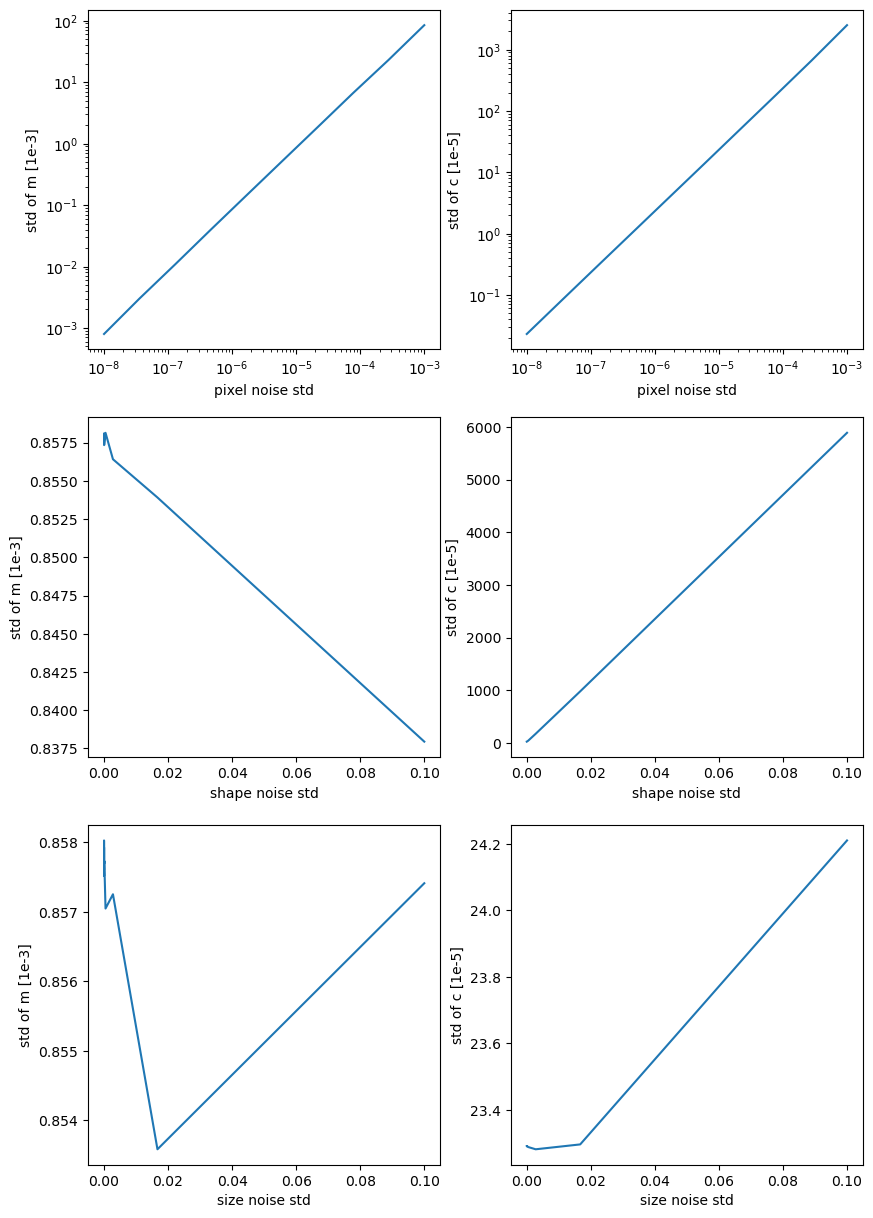

In [10]:
import matplotlib.pyplot as plt

def plot_m_and_c(pixel_noise_std_list,shape_noise_std_list,size_noise_std_list):

    plt.figure(figsize=(10,15))

    plt.subplot(3,2,1)
    plt.plot(pixel_noise_std_range,[i[0] for i in pixel_noise_std_list])
    plt.xlabel('pixel noise std')
    plt.ylabel('std of m [1e-3]')
    plt.xscale('log')
    plt.yscale('log')
    plt.subplot(3,2,2)
    plt.plot(pixel_noise_std_range,[i[1] for i in pixel_noise_std_list])
    plt.xlabel('pixel noise std')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('std of c [1e-5]')

    plt.subplot(3,2,3)
    plt.plot(shape_noise_std_range,[i[0] for i in shape_noise_std_list])
    plt.xlabel('shape noise std')
    plt.ylabel('std of m [1e-3]')
    plt.subplot(3,2,4)
    plt.plot(shape_noise_std_range,[i[1] for i in shape_noise_std_list])
    plt.xlabel('shape noise std')
    plt.ylabel('std of c [1e-5]')
    
    
    plt.subplot(3,2,5)
    plt.plot(size_noise_std_range,[i[0] for i in size_noise_std_list])
    plt.xlabel('size noise std')
    plt.ylabel('std of m [1e-3]')
    plt.subplot(3,2,6)
    plt.plot(size_noise_std_range,[i[1] for i in size_noise_std_list])
    plt.xlabel('size noise std')
    plt.ylabel('std of c [1e-5]')
    plt.show()


plot_m_and_c(pixel_noise_std_list,shape_noise_std_list,size_noise_std_list)